In [ ]:
!pip install yfinance pandas numpy matplotlib gymnasium stable-baselines3[extra] torch
!pip install gym==0.26.2
!pip install gym==0.26.2






import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings


warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827729 sha256=d29b2ceedbd35f78c68d894f14b457b35c94ab6339b91991e1852e119a0513ff
  Stored in directory: /root/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
ticker = input("Enter stock ticker (default 'AAPL'): ") or "AAPL"
ticker = ticker.strip().upper()
if ticker == "":
    ticker = "AAPL"

print(f"\nDownloading data for {ticker}...")

Enter stock ticker (default 'AAPL'): AAPL



In [ ]:
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(years=5)
df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"),
                end=end_date.strftime("%Y-%m-%d"), progress=False)
df.dropna(inplace=True)

In [ ]:
if 'Adj Close' in df.columns:
    price_col = 'Adj Close'
elif 'Close' in df.columns:
    price_col = 'Close'
else:
    # If multi-index columns, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
        if 'Adj Close' in df.columns:
            price_col = 'Adj Close'
        elif f'Adj Close_{ticker}' in df.columns:
            df.rename(columns={f'Adj Close_{ticker}': 'Adj Close'}, inplace=True)
            price_col = 'Adj Close'
        elif 'Close' in df.columns:
            price_col = 'Close'
        elif f'Close_{ticker}' in df.columns:
            df.rename(columns={f'Close_{ticker}': 'Close'}, inplace=True)
            price_col = 'Close'
        else:
            raise ValueError(f"Could not find price column in downloaded data. Columns: {df.columns.tolist()}")
    else:
        raise ValueError(f"Could not find 'Adj Close' or 'Close' column. Available columns: {df.columns.tolist()}")

# Standardize to 'Adj Close' for rest of code
if price_col != 'Adj Close':
    df['Adj Close'] = df[price_col]

# Use 'Adj Close' as price, and compute daily returns
df['Return'] = df['Adj Close'].pct_change().fillna(0)

print(f"Downloaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")

Downloaded 1256 days of data from 2020-10-05 to 2025-10-03


In [ ]:
# Split into 80% train / 20% test by time
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index].reset_index(drop=True)
test_df  = df.iloc[split_index:].reset_index(drop=True)

print(f"Train set: {len(train_df)} days, Test set: {len(test_df)} days\n")

Train set: 1004 days, Test set: 252 days



In [ ]:
import gym
from gym import spaces
import numpy as np

class CustomStockEnv(gym.Env):
    """
    Custom Stock Trading Environment for one stock with discrete actions:
    0 = Sell 1 share, 1 = Hold, 2 = Buy 1 share.
    Reward = change in portfolio - risk_penalty * current_drawdown.
    """
    metadata = {'render_modes': ['human']}

    def __init__(self, df):
        super(CustomStockEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.max_steps = len(df) - 1
        self.initial_balance = 10000.0
        self.current_step = 0

        # Actions: 0 = sell, 1 = hold, 2 = buy
        self.action_space = spaces.Discrete(3)
        # Observations: [price_norm, cash_norm, shares_norm]
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(3,), dtype=np.float32)

    def reset(self, seed=None, options=None):
      super().reset(seed=seed)
      self.balance = self.initial_balance
      self.shares_held = 0
      self.max_net_worth = self.initial_balance
      self.current_step = 0



      price = float(self.df.loc[self.current_step, "Adj Close"])
      state = np.array([
        price / self.initial_balance,
        self.balance / self.initial_balance,
        self.shares_held
    ], dtype=np.float32)

      return state, {}




    def step(self, action):
        price = float(self.df.loc[self.current_step, "Adj Close"])
        prev_portfolio = self.balance + self.shares_held * price

        # Execute action
        if action == 0 and self.shares_held > 0:
            self.balance += price
            self.shares_held -= 1
        elif action == 2 and self.balance >= price:
            self.balance -= price
            self.shares_held += 1

        self.current_step += 1
        done = self.current_step >= self.max_steps

        price = float(self.df.loc[self.current_step, "Adj Close"])
        current_portfolio = self.balance + self.shares_held * price
        self.max_net_worth = max(self.max_net_worth, current_portfolio)
        drawdown = (self.max_net_worth - current_portfolio) / (self.max_net_worth + 1e-8)

        profit = current_portfolio - prev_portfolio
        reward = float(profit - 5.0 * drawdown)

        state = np.array([
            price / self.initial_balance,
            self.balance / self.initial_balance,
            self.shares_held
        ], dtype=np.float32)
        info = {"portfolio_value": current_portfolio}

        terminated = self.current_step >= self.max_steps
        truncated = False
        return state, reward, terminated, truncated, info


In [ ]:
!pip install "shimmy>=2.0"

print("Setting up training environments...")
from stable_baselines3.common.vec_env import VecMonitor

train_env_ppo = VecMonitor(DummyVecEnv([lambda: CustomStockEnv(train_df)]))
train_env_dqn = VecMonitor(DummyVecEnv([lambda: CustomStockEnv(train_df)]))


Setting up training environments...


In [ ]:
print("\nTraining PPO model...")
model_ppo = PPO("MlpPolicy", train_env_ppo, verbose=0,
                learning_rate=0.0003,
                n_steps=2048,
                batch_size=64,
                n_epochs=10)
print(type(train_env_ppo.reset()))




Training PPO model...
<class 'numpy.ndarray'>


In [ ]:
model_ppo.learn(total_timesteps=50000)
print("PPO training complete!")

PPO training complete!


In [ ]:
print("\nTraining DQN model...")
model_dqn = DQN("MlpPolicy", train_env_dqn, verbose=0,
                learning_rate=0.0001,
                buffer_size=50000,
                learning_starts=1000,
                batch_size=32,
                tau=0.005,
                gamma=0.99,
                train_freq=4,
                target_update_interval=1000,
                exploration_fraction=0.1,
                exploration_initial_eps=1.0,
                exploration_final_eps=0.05)
model_dqn.learn(total_timesteps=50000)
print("DQN training complete!")


Training DQN model...
DQN training complete!


In [ ]:
def evaluate_model(model, env, test_df):
    obs = env.reset()
    portfolio_values = [env.envs[0].initial_balance]

    for _ in range(len(test_df) - 1):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        portfolio_values.append(info[0]['portfolio_value'])
        if done[0]:  # done is now an array in DummyVecEnv
            break

    portfolio_values = np.array(portfolio_values)

    # Ensure we have the right length
    if len(portfolio_values) < len(test_df):
        last_val = portfolio_values[-1] if len(portfolio_values) > 0 else env.envs[0].initial_balance
        while len(portfolio_values) < len(test_df):
            portfolio_values = np.append(portfolio_values, last_val)

    return portfolio_values[:len(test_df)]

print("\nEvaluating models on test set...")


Evaluating models on test set...


In [ ]:
test_env_ppo = DummyVecEnv([lambda: CustomStockEnv(test_df)])
test_env_dqn = DummyVecEnv([lambda: CustomStockEnv(test_df)])

portf_ppo = evaluate_model(model_ppo, test_env_ppo, test_df)
portf_dqn = evaluate_model(model_dqn, test_env_dqn, test_df)

# Create buy-and-hold benchmark
initial_price = test_df.loc[0, 'Adj Close']
shares_bh = float(10000 / initial_price)
portf_buyhold = test_df['Adj Close'].values * shares_bh

In [ ]:
def compute_metrics(portfolio):
    returns = np.diff(portfolio) / (portfolio[:-1] + 1e-8)
    total_return = (portfolio[-1]/portfolio[0] - 1) * 100  # as percentage
    # Daily Sharpe (assuming zero risk-free rate) and annualize
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-8)) * np.sqrt(252)
    # Max drawdown
    peak = np.maximum.accumulate(portfolio)
    drawdowns = (peak - portfolio) / (peak + 1e-8)
    max_dd = np.max(drawdowns) * 100  # as percentage
    volatility = np.std(returns) * np.sqrt(252) * 100  # annualized, as percentage
    return total_return, sharpe, max_dd, volatility


metrics = {
    "PPO": compute_metrics(portf_ppo),
    "DQN": compute_metrics(portf_dqn),
    "Buy & Hold": compute_metrics(portf_buyhold),
}

In [ ]:
metrics_df = pd.DataFrame(metrics, index=["Total Return (%)", "Sharpe Ratio", "Max Drawdown (%)", "Volatility (%)"])
metrics_df = metrics_df.T.round(4)

print("\n" + "="*60)
print("PERFORMANCE METRICS (Test Set)")
print("="*60)
print(metrics_df)
print("="*60)


PERFORMANCE METRICS (Test Set)
            Total Return (%)  Sharpe Ratio  Max Drawdown (%)  Volatility (%)
PPO                   0.3229        0.4833            0.8583          0.6743
DQN                   1.9815        0.5060            5.0657          4.0561
Buy & Hold           14.3050        0.5752           33.3605         32.2991


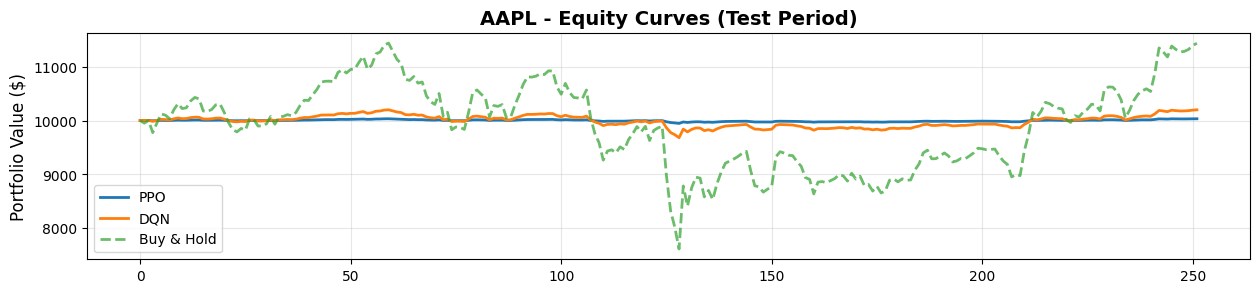

In [ ]:
plt.figure(figsize=(15, 10))

# Equity curves
plt.subplot(3, 1, 1)
plt.plot(portf_ppo, label='PPO', linewidth=2)
plt.plot(portf_dqn, label='DQN', linewidth=2)
plt.plot(portf_buyhold, label='Buy & Hold', linewidth=2, linestyle='--', alpha=0.7)
plt.title(f'{ticker} - Equity Curves (Test Period)', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

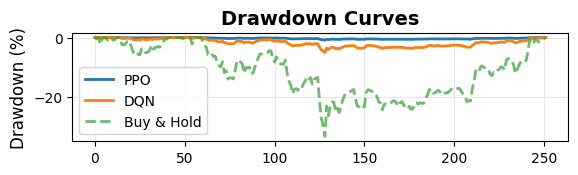

In [ ]:
plt.subplot(3, 1, 2)
def drawdown_curve(portfolio):
    peak = np.maximum.accumulate(portfolio)
    drawdown = (portfolio - peak) / (peak + 1e-8) * 100  # as percentage
    return drawdown

plt.plot(drawdown_curve(portf_ppo), label='PPO', linewidth=2)
plt.plot(drawdown_curve(portf_dqn), label='DQN', linewidth=2)
plt.plot(drawdown_curve(portf_buyhold), label='Buy & Hold', linewidth=2, linestyle='--', alpha=0.7)
plt.title('Drawdown Curves', fontsize=14, fontweight='bold')
plt.ylabel('Drawdown (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)


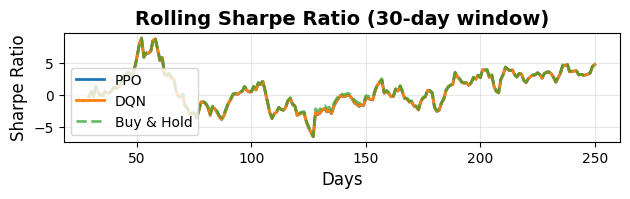


✅ Analysis complete!


In [ ]:
plt.subplot(3, 1, 3)
window = 30
for portf, label, style in zip([portf_ppo, portf_dqn, portf_buyhold],
                                ['PPO', 'DQN', 'Buy & Hold'],
                                ['-', '-', '--']):
    daily_ret = np.diff(portf) / (portf[:-1] + 1e-8)
    rolling_sharpe = pd.Series(daily_ret).rolling(window).mean() / (pd.Series(daily_ret).rolling(window).std() + 1e-8)
    rolling_sharpe = rolling_sharpe * np.sqrt(252)
    plt.plot(rolling_sharpe, label=label, linewidth=2, linestyle=style, alpha=0.7 if style == '--' else 1.0)

plt.title('Rolling Sharpe Ratio (30-day window)', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Analysis complete!")